# CONTROLLABILITY OF BIOLOGICAL SYSTEMS

This notebook explores the construction and interpretation of transfer functions for more complex networks.

# Preliminaries

In [1]:
!pip -q install controlSBML
import controlSBML as ctl
import control
from controlSBML.util import makeSimulationTimes

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te
import sympy
print("controlSBML version: " + ctl.__version__)

controlSBML version: 0.2.10


# Transfer Functions in the ``control`` Package

Suppose our transfer function is $G(s) = \frac{1}{s} \frac{k_1}{k_2 + s}$.

The ``control`` packages provides a way to construct transfer functions that are a ratio of
polynomials in $s$.

## Representing Polynomials

A polynomial in $s$ is represented as a ``python`` list.
For example, $s + k_2$ is the polynomial $(1)s^1 + (k_2) s^0$.
It is represented by the list ``[1, k2]``, where ``k2`` is the floating point value of $k_2$.
The interpretation is that the last element of the list is the coefficient of $s^0$;
elements that preceed the last element represent successive powers of $s$.

**Question: What is the list that represents the polynomial $3 S^3 + 2s$?**

## Creating Transfer Functions

To create a transfer function, you provide the numerator and denominator polynomial.
Consider the construction of the transfer function for
$G(s) = \frac{1}{s} \frac{k_1}{k_2 + s} = \frac{k_1}{s^2 + k_2 s}$.

**Question: What are the poles of $G(s)$?**

In [2]:
k1 = 1
k2 = 2
tf = control.TransferFunction([k1], [1, k2, 0])
tf

TransferFunction(array([1]), array([1, 2, 0]))

## Using ``TransferFunction`` objects

There are several ways to use transfer function objects.
You can find the poles, calculate DC gain, and simulate impulse and step responses.

### Poles of a TransferFunction

In [3]:
# The poles should be 0, -k2 = -2
tf.pole()

array([-2.,  0.])

### DC Gain of a TransferFunction

In [4]:
tf.dcgain()

inf

**Question: Why is DC Gain = $\infty$?**

### Impulse Response

In [5]:
# You can use controlSBML to make a sequence of simulation times. By default it's in increments
# of 0.1 from 0 to 5.
TIMES = ctl.makeSimulationTimes(end_time=10, points_per_time=5)
TIMES

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
        2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
        4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
        6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
        8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. ])

In [6]:
result = control.impulse_response(tf, T=TIMES)

``result`` is complicated objects with many properties.
* ``result.outputs`` - ``result.outputs[n]`` is a time series for the output ``n``
* ``result.t`` - times simulated (which should be the same as ``TIMES``)

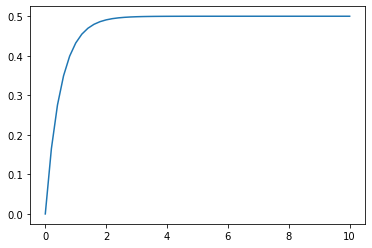

In [7]:
# Since we're doing single input single output (SISO) systems,
# you can simplify matters by just flattening result.t, result.outputs
plt.plot(result.t.flatten(), result.outputs.flatten())

**Question: The above impulse response converges to 0.5. How is this predicted by $G(s)$?**

Hint: Recall that for an impulse input, $y(\infty) = lim_{s \rightarrow 0} s G(s)$.

### Step Response

**Question: Does $G(s)$ converge for a step response? If so, to what value?**

Hint: Recall that for a step input, $y(\infty) = lim_{s \rightarrow 0}  G(s)$.

Consider $H(s) = \frac{k_1}{s + k_2}$.

**Question: Construct ``control.TransferFunction`` object for $H(s)$. if $k_2 = 3$.**

**REMOVE**

In [8]:
k2 = 3
tf = control.TransferFunction([k1], [1, k2])
tf

TransferFunction(array([1]), array([1, 3]))

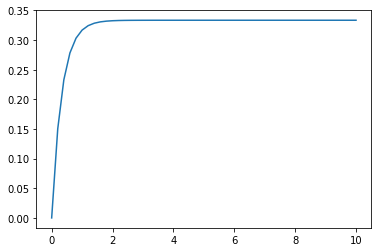

In [9]:
result = control.step_response(tf, T=TIMES)
plt.plot(result.t.flatten(), result.outputs.flatten())

**Question: The above step response converges to 0.33. How is this predicted by $H(s)$?**

# State Space Representation in the ``control`` Package

Consider the reaction network

    S1 -> S2 + S3; k1*S1
    S2 -> S3;      k2*S2
    S3 ->   ;  k3*S3
    
    k1 = 0.5
    k2 = 1.5
    k3 = 0.75


**Question: What are the system equations for this network?**

**REMOVE**

\begin{eqnarray}
\dot{S}_1 & = & - k_1 S_1 \\
\dot{S}_2 & = & k_1 S_1 - k_2 S_2 \\
\dot{S}_3 & = & k_1 S_1 + k_2 S_2 - k_3 S_3 \\
\end{eqnarray}

A state space representation of a SISO system is:

\begin{eqnarray}
\dot{\bf x} & = & {\bf A} {\bf x} + {\bf b} u \\
y & = & {\bf c} {\bf x}
\end{eqnarray}

where
* ${\bf x}$ is a vector of state
* $u$ is the scalar input
* $y$ is the scalar output
* ${\bf A}$, a matrix of constants, describes the relationships between state variables
* ${\bf b}$ is a column vector that indicates how the input affects each state
* ${\bf c}$ is a row vector that specifies how each state contributes to the output

### Creating State Space Objects for SISO Systems

The ${\bf A}$ matrix is an alternative representation of the state equations.
The rows are the equations.
In our example, row 2 is the equation for $\dot{S}_2$.
(Of course, the python index for this row is 1.)
The columns, represent the state variable.
So, column 3 is for $S_3$.

That is
$\dot{\bf x} = 
{\bf A} =
\begin{bmatrix}
-k_1 & 0 & 0\\
k_1 & -k_2 & 0  \\
k_1 & k_2 & -k_3
\end{bmatrix}
{\bf x} + {\bf b}u$.

**Question: If the input is $S_1$, what is ${\bf b}$?**

**REMOVE**

${\bf b} =
\begin{bmatrix}
1 \\
0 \\
0 \\
\end{bmatrix}.
$

### Creating ``control.StateSpace`` objects

Consider a system with $S_1$ as input and $S_3$ as output.

In [10]:
k1 = 0.5
k2 = 1.5
k3 = 0.75

A = np.array( [ [-k1, 0, 0],
    [k1, -k2, 0],
     [k1, k2, -k3]])
B = [1, 0, 0]
C = [0, 0, 1]
state_space = control.StateSpace(A, B, C, 0)
state_space

StateSpace(array([[-0.5 ,  0.  ,  0.  ],
       [ 0.5 , -1.5 ,  0.  ],
       [ 0.5 ,  1.5 , -0.75]]), array([[1.],
       [0.],
       [0.]]), array([[0., 0., 1.]]), array([[0.]]))

### Using State Space Objects

* simulation: ``control.input_output_response``
* convert to transfer function (since this is easier to deriving the transfer function: ``control.ss2tf``

In [11]:
tf = control.ss2tf(state_space)
tf

TransferFunction(array([0.5, 1.5]), array([1.    , 2.75  , 2.25  , 0.5625]))

In [12]:
tf.dcgain()

2.6666666666666683

# mTOR Signaling

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-017-18400-z/MediaObjects/41598_2017_18400_Fig1_HTML.jpg"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />

For your homework, you create a state space object for an SBML model.
1. Load the model into Tellurium
1. Simulate to the time for the operating point.
1. Construct ${\bf A}$ from the Jacobian (``getFullJacobian``).
1. Construct ${\bf b}$ based on the index of the chemical species being controlled.
1. Construct ${\bf c}$ based on the index of the chemical species for the output.
1. ``state_space = control.StateSpace(A, b, c, 0)``.

## Constructing State Space Objects from Tellurium

In [19]:
rr = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml")
#print(rr.getAntimony())

There's a some work to get the indices right to construct ${\bf b}$, ${\bf c}$,
and to get the species names.

## Constructing ``control`` objects using ``controlSBML``

In [24]:
ctlsb = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml",
                       input_names=["pAkt"], output_names=["mTORC1_DEPTOR"])
mtor_nl = ctlsb.makeNonlinearIOSystem("mtor")
mtor_ss = ctlsb.makeStateSpace()
MTOR_TF = ctlsb.makeTransferFunction(atol=1e-5, time=1)

## Controllability Analysis

Suppose that we want to control the complex ``mTORC1_DEPTOR``.
What inputs should we control?
We start by controlling the amount of insullin.

In [25]:
MTOR_TF

TransferFunction(array([-0.03472222, -0.1616584 , -0.09749342, -0.00188548]), array([ 1.        , 11.05327667, 34.95692263, 29.04801534,  7.37855958,
        0.13622988]))

In [26]:
MTOR_TF.dcgain()

-0.013840450064546183

In [29]:
MTOR_TF.pole()

array([-5.99984811, -3.96034236, -0.57142857, -0.50165764, -0.02      ])